# Background

Example on how to perform time series forecasting using ARIMA (non-seasonal) or SARIMA (seasonal) models

#### Let's obtain example data sets

In [1]:
from pandas import DataFrame     # used for type hinting
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from typing import Iterable      # used for type hinting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#### Seaborn library has some built-in sample data sets that we can obtain

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

#### `flights` data set has seasonal trend, so let's go get it

In [20]:
# sns.load_dataset() returns a Pandas dataframe
flights = sns.load_dataset('flights')
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


## Data Prep Work

To perform time series forecasting with Python's time series libraries, they often require that the dates are actual date date type.  In its current form, our data set has year and month in separate columns, where year is an integer type and month is categorical data type:

In [4]:
flights.dtypes

year             int64
month         category
passengers       int64
dtype: object

So our data set lacks actual dates.  Therefore, we will need to do some data wrangling to create the desired date column.  We will perform the following data transformations:
- Combine year, month, and '01' to create date values using string concatenation to create `year_month` column
- After concatenation, the date values are in `str` data type, so we must still perform final step of converting string dates to actual date data type
- Set the date as the dataframe index
- Don't inclue the redundant year and month columns

In [21]:
flights = flights.assign(
    year_month=pd.to_datetime(
        '01' + '-' + flights['month'].astype(str) + '-' + flights['year'].astype(str)
    )
).set_index('year_month')

#### Now let's see what our sample data set looks like now

In [22]:
flights = flights[['passengers']]

In [23]:
flights.head()

,passengers
year_month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Let's also confirm the data type of year_month dataframe index

In [25]:
type(flights.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Visualizing / Plotting the Data

#### Let's plot the flight's monthly passenger counts

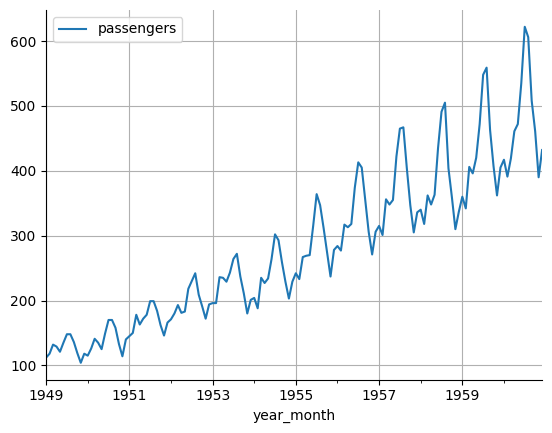

In [26]:
flights.plot(use_index=True, y='passengers')
sns.despine()
plt.grid(visible=True)
plt.show()

#### Plot more granular / monthly chart

We suspect seasonality, so let's plot a portion or subset of data: a few years' worth of data so that we can visiblly see passenger counts at the monthly level and see where counts are spiking during similar months.  Let's plot 1957 thru 1959 years' worth of data:

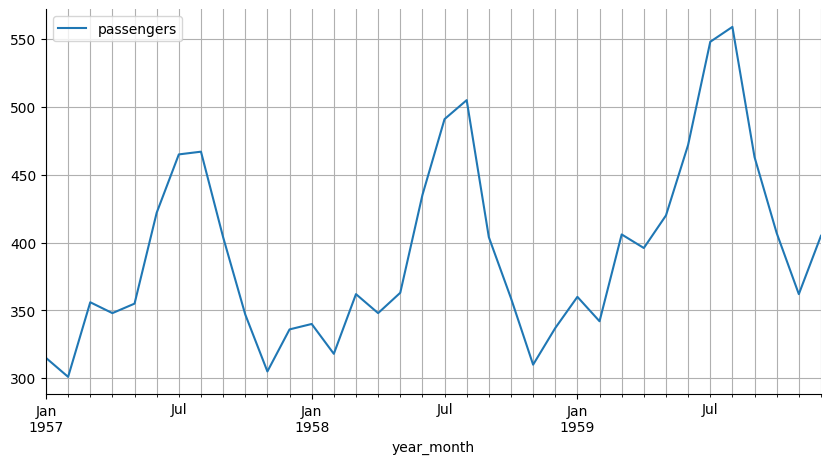

In [33]:
flights['1957':'1959'].plot(use_index=True, y='passengers', figsize=(10,5))
plt.grid(which='both', visible=True)
sns.despine()
plt.show()

#### Observations and Assumptions
- There is upward trend
- There is seasonality: rise in travel during summer months and end of the year
- Data is most likely not stationary

# Testing for Stationarity

- Augmented Dickey-Fuller (ADF) Test (non-visual method)
- Rolling statistics (visual method)
- Custom function that performs both ADF test and plots rolling statistics plots

#### ADF Test

Python's `statsmodels` library includes the Augmented Dickey-Fuller (ADF) Test to test for stationarity

In [34]:
from statsmodels.tsa.stattools import adfuller

Some information about the adfuller function:

In [35]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(x, maxlag: 'int | None' = None, regression='c', autolag='AIC', store=False, regresults=False)
    Augmented Dickey-Fuller unit root test.
    
    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.
    
    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : {None, int}
        Maximum lag which is included in test, default value of
        12*(nobs/100)^{1/4} is used when ``None``.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.
    
        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.
    
    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among the
      

Let's pass in or provide the passengers count to this adfuller() function and see what happens:

In [36]:
adfuller(flights['passengers'])

(0.8153688792060352,
 0.9918802434376408,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

From above, we can see the output is not very informative and we would have to refer to the built-in documentation to determine what those outputs correspond to.  Instead, we will create a custom function that will present the results in a more user-friendly and informative manner.

In [37]:
def adfuller_test(data: Iterable):
    """
    Function to output the ADF test statistics in a more informative, user-friendly manner

    Parameters
    ----------
    data : Iterable / sequence type
        - Data that we want to test for stationarity

    Returns
    -------
    ADF test statistics in a more informative, user-friendly manner
    """
    
    result=adfuller(data.dropna())
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical Values']
    for value,label in zip(result,labels):
        print(f'{label} : {str(value)}')
    if result[1] <= 0.05:
        print("Strong evidence to reject the null hypothesis that data is non-stationary.  Therefore, data is most likely stationary.")
    else:
        print("Weak evidence against null hypothesis.  Therefore, data is most likely non-stationary")

#### Now let's use our custom function

In [38]:
adfuller_test(flights['passengers'])

ADF Test Statistic : 0.8153688792060352
p-value : 0.9918802434376408
#Lags Used : 13
Number of Observations Used : 130
Critical Values : {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
Weak evidence against null hypothesis.  Therefore, data is most likely non-stationary


From the output above, we see this is more informative and user-friendly.

#### Rolling Statistics to test for stationarity (visual method)

Another way to test for stationarity is to see if there is upward/downward trend or if the variance is not steady or random by visually inspecting plots of rolling mean and rolling standard deviation.

#### Let's create new columns containing rolling mean and rolling standard deviation with a 12-month window

In [39]:
flights = flights.assign(rolling_mean=flights['passengers'].rolling(window=12).mean())
flights = flights.assign(rolling_std_dev=flights['passengers'].rolling(window=12).std())            

In [40]:
flights.head(n=15)

,passengers,rolling_mean,rolling_std_dev
year_month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,NaN,NaN
1949-07-01,148,NaN,NaN
1949-08-01,148,NaN,NaN
1949-09-01,136,NaN,NaN


#### Now let's plot the passenger counts, rolling mean, and rolling standard deviation with a 12-month window

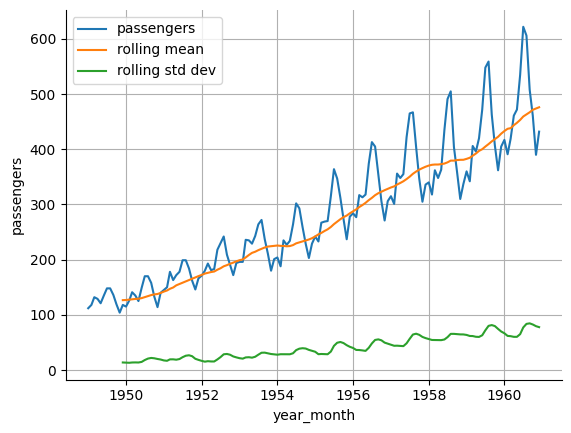

In [42]:
sns.lineplot(data=flights, x=flights.index, y='passengers', label='passengers')
sns.lineplot(data=flights, x=flights.index, y=flights['passengers'].rolling(window=12).mean(), label='rolling mean')
sns.lineplot(data=flights, x=flights.index, y=flights['passengers'].rolling(window=12).std(), label='rolling std dev')
sns.despine()
plt.grid(visible=True)
plt.show()

From above, we see that the rolling mean and standard deviation are not random: both rolling mean and standard deviation are increasing

#### Let's modify our custom function to provide both ADF test and rolling statistics plots

NOTE: This custom function won't create rolling mean / standard deviation columns - will keep the data in its original form

In [43]:
def adfuller_test(data: DataFrame, y: str, window: int):
    """
    Function to output the ADF test statistics in a more informative, user-friendly manner
    and also plots rolling mean and standard deviation with the specified window size

    Parameters
    ----------
    data : Pandas dataframe
        - dataframe that has the data we want to check for stationarity
    y : str
        - y value that we want to perform the ADF test on and also the y value to plot
    window: int
        - the window size for the rolling statistics

    Returns
    -------
    ADF test statistics in a more informative, user-friendly manner and rolling statistics plots
    """

    result=adfuller(data.dropna()[y])
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical Values']
    for value,label in zip(result,labels):
        print(f'{label} : {str(value)}')

    print("H\u2080/null hypothesis: Data is non-stationary")
    
    # result[1] is the p-value
    if result[1] <= 0.05:
        print('\n')
        print("Strong evidence to reject the null hypothesis that data is non-stationary.  Therefore, data is most likely stationary.")
    else:
        print('\n')
        print("Weak evidence against null hypothesis.  Therefore, data is most likely non-stationary")

    print('\n\n')
    print(f'Plots of rolling mean and standard deviation with window = {window}')

    sns.lineplot(data=data, x=data.index, y=y, label=y)
    sns.lineplot(data=data, x=data.index, y=data[y].rolling(window=window).mean(), label='rolling mean')
    sns.lineplot(data=data, x=data.index, y=data[y].rolling(window=window).std(), label='rolling std dev')
    sns.despine()
    plt.grid(visible=True)
    plt.show()

In [ ]:
help(adfuller_test)

ADF Test Statistic : 0.6915787403700747
p-value : 0.9896683018995455
#Lags Used : 13
Number of Observations Used : 119
Critical Values : {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
H₀/null hypothesis: Data is non-stationary


Weak evidence against null hypothesis.  Therefore, data is most likely non-stationary



Plots of rolling mean and standard deviation with window = 12


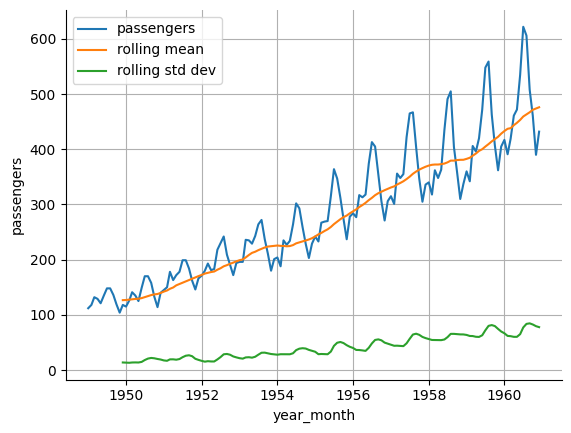

In [44]:
adfuller_test(flights, y='passengers', window=12)

So now we see our data is not stationary.  Now what?  Our next course of action is to make the data stationary.

In [45]:
auto_arima(flights['passengers'], m=12, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=1.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.26 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.93 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.30 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.87 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.14 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.26 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.72 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.72 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=1.47 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.12 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.11 sec
 ARIMA(3,1,1)(0,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood                -504.923
Date:                             Sat, 30 Sep 2023   AIC                           1017.847
Time:                                     10:58:48   BIC                           1029.348
Sample:                                 01-01-1949   HQIC                          1022.520
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5960      0.085      6.986      0.000       0.429       0.763
ar.L2          0.2143      0.091      2.343      0.019       0.035       0.394
ma.L1         -0.9819      0.038    -25.597      0.000      -1.057      -0.907
sigma2       129.3185     14.558      8.883      0.000     100.786     157.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.98   Prob(JB):                         0.02
Heteroskedasticity (H):               2.33   Skew:                            -0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Making our data stationary

Four ways to make our data stationary:

1. Time shift and then differencing
2. Taking the log of our data
3. Taking the cube root or square root of our data
4. Combination of above (ex. time shift and also taking the log)

#### Time Shift Method

First, let's remind ourself, what our data currently looks like:

In [46]:
flights.head()

,passengers,rolling_mean,rolling_std_dev
year_month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


#### Let's start with a clean slate and just keep the `year_month` and `passengers` columns

In [48]:
flights = flights[['passengers']]

In [49]:
flights.head()

,passengers
year_month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Now, let's create a new column that contains shifted values.  Since we have seasonality that is repeating every 1 year or 12 months, we will shift by 12 months

Pandas dataframe has a handy, built-in function to create shifts for us.

In [50]:
flights = flights.assign(shift12 = flights['passengers'].shift(12))

Let's confirm we have successfully create our new `shift12` column

In [51]:
flights.head(n=15)

,passengers,shift12
year_month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
1949-06-01,135,NaN
1949-07-01,148,NaN
1949-08-01,148,NaN
1949-09-01,136,NaN


#### Now let's create a new column `diff12` that represents the difference between actual or passengers value and the shifted value

NOTE: Pandas also has a `diff()` method that will perform shift and differencing at the same time.  But I'd rather see the shift and diff columns separately so that it is more apparent what I am doing.

In [52]:
flights = flights.assign(diff12 = flights['passengers'] - flights['shift12'])

In [53]:
flights.head(n=15)

,passengers,shift12,diff12
year_month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,NaN,NaN
1949-07-01,148,NaN,NaN
1949-08-01,148,NaN,NaN
1949-09-01,136,NaN,NaN


#### Now, let's perform the ADF test on the shift difference or `diff12`

ADF Test Statistic : -3.3830207264924796
p-value : 0.011551493085515008
#Lags Used : 1
Number of Observations Used : 130
Critical Values : {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}
H₀/null hypothesis: Data is non-stationary


Strong evidence to reject the null hypothesis that data is non-stationary.  Therefore, data is most likely stationary.



Plots of rolling mean and standard deviation with window = 12


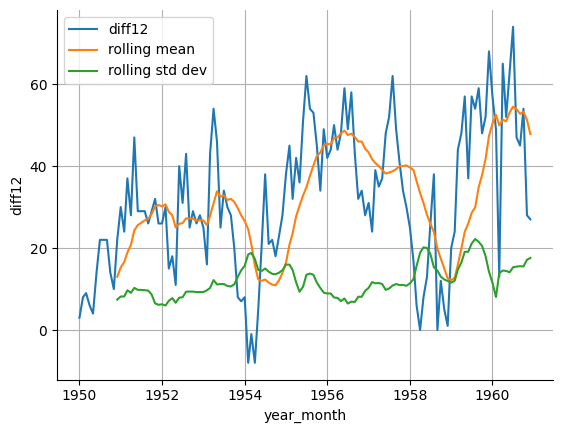

In [57]:
adfuller_test(data=flights, y='diff12', window=12)

## Obtain ARIMA parameters: p, d, q

- We obtain `p` parameter by observing the PACF plot
- We obtain `q` parameter by observing the ACF plot
- We obtain `d` parameter based on the amount of shift differencing

#### statsmodels have plot_acf() and plot_pacf() methods to plot ACF and PACF plots, respectively

In [58]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [59]:
flights.head()

,passengers,shift12,diff12
year_month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


#### Now, let's plot the PACF plot to determine the `p` parameter

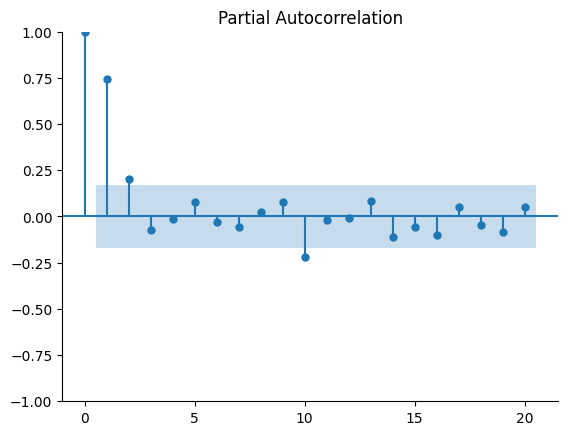

In [60]:
plot_pacf(flights['diff12'].dropna(), lags=20)
sns.despine()
plt.show()

Based on the PACF plot above, we would choose 2 as the value for our `p` parameter because it is until after the 2nd lag that our lags start to fall into the shaded region of the confidence interval.

#### Let's plot the ACF plot to determine the `q` parameter

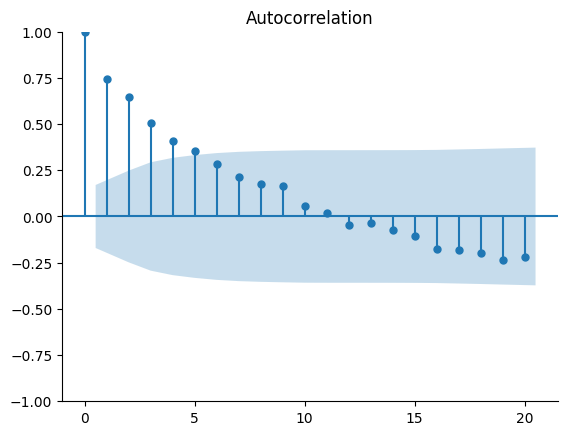

In [61]:
plot_acf(flights['diff12'].dropna(), lags=20)
sns.despine()
plt.show()

From the ACF plot above, we see the lags taper downwards slowly.  In this case, rule of thumb is to set the value of q to the value we have for p, which is 1.

For the `d` parameter, we would use 1 since we applied differencing only once.

Since we now have values for the `p`(2), `d`(1), and `q`(1) parameters, we can start to build our ARIMA model.  But we need to first split our data into training set and test set.

## Split our data into training and test data sets

I will arbitrarily make our training data to consist of 70% of the data.

In [62]:
flights.head()

,passengers,shift12,diff12
year_month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


In [63]:
len(flights)

144

In [64]:
round(len(flights) * 0.7)

101

From above, we see that we will reach 70% of our data with 101 rows of data.  We will use Python's index slicing syntax to create a subset of our original data to consist of the first 101 rows.

In [65]:
training_data = flights[:round(len(flights) * 0.7)]

In [66]:
len(training_data) # should be 101 rows of data

101

In [67]:
training_data.tail()

,passengers,shift12,diff12
year_month,,,
1957-01-01,315,284.0,31.0
1957-02-01,301,277.0,24.0
1957-03-01,356,317.0,39.0
1957-04-01,348,313.0,35.0
1957-05-01,355,318.0,37.0


From above we see that our last data was for May 1957.

In [68]:
test_data = flights[round(len(flights) * 0.7):]

In [69]:
test_data.head()

,passengers,shift12,diff12
year_month,,,
1957-06-01,422,374.0,48.0
1957-07-01,465,413.0,52.0
1957-08-01,467,405.0,62.0
1957-09-01,404,355.0,49.0
1957-10-01,347,306.0,41.0


In [70]:
test_data.tail()

,passengers,shift12,diff12
year_month,,,
1960-08-01,606,559.0,47.0
1960-09-01,508,463.0,45.0
1960-10-01,461,407.0,54.0
1960-11-01,390,362.0,28.0
1960-12-01,432,405.0,27.0


In [71]:
len(test_data)

43

#### Let's confirm that our training data plus test data equals 144 rows of data

In [72]:
assert len(training_data) + len(test_data) == 144

#### Now that we have our training and test data sets made, we can train our ARIMA model with the training data

In [73]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# order = (p, d, q)
model_arima = SARIMAX(training_data['passengers'], order=(2, 1, 1), seasonal_order=(2,1,1,12)).fit()
model_arima.summary()

In [ ]:
# order = (p, d, q)
model_arima = SARIMAX(training_data['passengers'], order=(1, 1, 1), seasonal_order=(1,1,1,12)).fit()
model_arima.summary()

In [ ]:
# order = (p, d, q)
model_arima = SARIMAX(training_data['passengers'], order=(1, 1, 2), seasonal_order=(1,1,2,12)).fit()
model_arima.summary()

In [ ]:
# order = (p, d, q)
model_sarimax = SARIMAX(training_data['passengers'], order=(1, 1, 3), seasonal_order=(1,1,3,12)).fit()
model_sarimax.summary()